In [ ]:
# ==============================
# Import Libraries
# ==============================
import pandas as pd
import numpy as np
from PIL import Image
from io import BytesIO
import requests
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, HTML
from transformers import CLIPProcessor, CLIPModel
import torch

# ==============================
# Load Dataset
# ==============================
df = pd.read_csv("Abayas_alldata.csv")
df = df.dropna(subset=['p_img', 'p_name', 'p_base_price']).reset_index(drop=True)

# Clean price
df['p_base_price'] = (
    df['p_base_price']
    .astype(str)
    .str.replace('$', '')
    .str.replace(',', '')
    .astype(float)
)

# ==============================
#  Load CLIP Model
# ==============================
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "openai/clip-vit-large-patch14"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

# ==============================
#  Extract Embeddings (Batch)
# ==============================
image_embeddings = []
text_embeddings = []

batch_size = 16
num_batches = (len(df) + batch_size - 1) // batch_size

for b in range(num_batches):
    batch_df = df.iloc[b*batch_size : (b+1)*batch_size]

    # --- Images ---
    imgs = []
    for url in batch_df['p_img']:
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            imgs.append(img)
        except:
            imgs.append(None)  # image unavailable

    # Process images batch
    valid_imgs = [img for img in imgs if img is not None]
    if valid_imgs:
        inputs = processor(images=valid_imgs, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            emb_imgs = model.get_image_features(**inputs).cpu().numpy()
        # Map back to all batch
        idx_valid = 0
        for img in imgs:
            if img is not None:
                image_embeddings.append(emb_imgs[idx_valid])
                idx_valid += 1
            else:
                image_embeddings.append(np.zeros((model.config.projection_dim,)))
    else:
        for _ in imgs:
            image_embeddings.append(np.zeros((model.config.projection_dim,)))

    # --- Texts ---
    texts = batch_df['p_name'].tolist()
    inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        emb_texts = model.get_text_features(**inputs).cpu().numpy()
    text_embeddings.extend(emb_texts)

image_embeddings = np.array(image_embeddings)
text_embeddings = np.array(text_embeddings)

# ==============================
#  Normalize Embeddings
# ==============================
image_embeddings = normalize(image_embeddings)
text_embeddings = normalize(text_embeddings)

# ==============================
#  Combine Embeddings
# ==============================
# Adjust weights for better similarity (tweakable)
combined_embeddings = normalize(0.7*image_embeddings + 0.3*text_embeddings)
np.save("combined_embeddings.npy", combined_embeddings)
print("✅ Combined embeddings shape:", combined_embeddings.shape)

# ==============================
#  Nearest Neighbors
# ==============================
# Increase n_neighbors for better Top-K retrieval
knn = NearestNeighbors(n_neighbors=15, metric='cosine')
knn.fit(combined_embeddings)

# ==============================
#  Recommendation Function
# ==============================
def find_similar(query_idx, top_n=5):
    query_emb = combined_embeddings[query_idx].reshape(1, -1)
    distances, indices = knn.kneighbors(query_emb, n_neighbors=top_n+1)
    indices = indices.flatten()[1:]  # exclude the query itself
    recs = df.iloc[indices].copy()
    recs['similarity'] = 1 - distances.flatten()[1:]
    return recs

# ==============================
#  Display Recommendations
# ==============================
def display_recommendations(query_idx, top_n=5, thumb_size=(300,300)):
    display(HTML("<h4>Query Image</h4>"))
    try:
        response = requests.get(df.loc[query_idx,'p_img'], timeout=5)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img.thumbnail(thumb_size)
        display(img)
        display(HTML(f"<b>{df.loc[query_idx,'p_name']} | ${df.loc[query_idx,'p_base_price']}</b>"))
    except:
        print("Error loading query image")

    recs = find_similar(query_idx, top_n)
    display(HTML("<h4>Top Recommendations</h4>"))
    for idx, row in recs.iterrows():
        try:
            response = requests.get(row['p_img'], timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img.thumbnail(thumb_size)
            display(HTML(f"<b>{row['p_name']} | ${row['p_base_price']} | Similarity: {row['similarity']:.2f}</b>"))
            display(img)
        except:
            print("Error loading recommended image")




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✅ Combined embeddings shape: (334, 768)


In [ ]:
# ==============================
#  Evaluate Mean Top-5 Similarity
# ==============================
all_top5_sims = []
for i in range(len(df)):
    query_emb = combined_embeddings[i].reshape(1, -1)
    distances, indices = knn.kneighbors(query_emb, n_neighbors=6)
    sims = 1 - distances.flatten()[1:]
    all_top5_sims.append(np.mean(sims))

mean_top5_similarity = np.mean(all_top5_sims)
print(f"✅ Mean Top-5 Similarity: {mean_top5_similarity:.4f}")

# ==============================

✅ Mean Top-5 Similarity: 0.9046


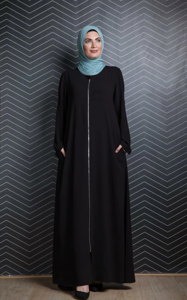

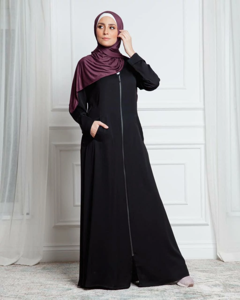

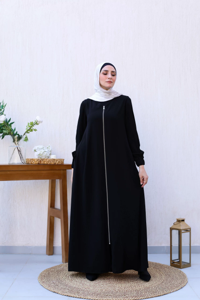

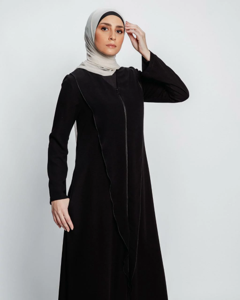

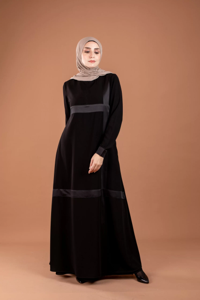

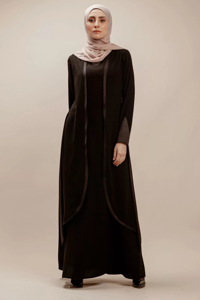

In [ ]:
#  Example Usage
# ==============================
query_idx = 100
display_recommendations(query_idx, top_n=5)
